In [16]:
#加载后面需要的库
import pandas as pd
import numpy as np
import copy
import os
import matplotlib.colors
import statsmodels.api as sm

from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.model_selection import StratifiedShuffleSplit,KFold, GridSearchCV, cross_val_score

from keras.utils import to_categorical
from keras.layers import Dense,RNN,LSTM,Activation,Dropout,Conv2D,MaxPooling2D,Flatten
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.wrappers.scikit_learn import KerasClassifier

import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn import svm
from sklearn.gaussian_process.kernels import  RBF
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.feature_selection import RFE, RFECV

from sklearn.metrics import classification_report, accuracy_score,auc,confusion_matrix,precision_score,recall_score,roc_auc_score,\
roc_curve,f1_score,precision_recall_curve,balanced_accuracy_score,matthews_corrcoef
from scipy import stats

import seaborn as sns
import collections
from itertools import cycle
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
import shap
import warnings
warnings.filterwarnings("ignore")


import os
os.chdir(r'F:\数据分析\jupyter\hw\20210319p')
print(os.listdir())

['.ipynb_checkpoints', 'AR_binding_CoMPARA_comput - copy.csv', 'AR_binding_CoMPARA_Eval_set - copy.csv', 'AR_binding_Tox21.csv', 'logs', 'pp.ipynb', '化合物预测.ipynb', '建模需求.txt']


### 1.数据预处理

In [2]:
dat1 = pd.read_csv('AR_binding_CoMPARA_comput - copy.csv',encoding='utf-8-sig',low_memory=False)
dat2 = pd.read_csv('AR_binding_CoMPARA_Eval_set - copy.csv',encoding='utf-8-sig',low_memory=False)
dat2.columns = dat1.columns
del dat1['Index']
del dat2['Index']

In [3]:
def f(x):
    if pd.isnull(x):
        return None
    else:
        if ',' in x:
            x = x.split(',')
            return float(x[0])*1000+float(x[1])
        else:
            return float(x)
ind = dat1.select_dtypes(include=[object]).columns.tolist().index('ASA')
for col in dat1.select_dtypes(include=[object]).columns.tolist()[ind:]:
    dat1[col] = dat1[col].apply(lambda x:f(x))
for col in dat2.select_dtypes(include=[object]).columns.tolist()[ind:]:
    dat2[col] = dat2[col].apply(lambda x:f(x))

In [4]:
null_rate = pd.DataFrame()
g = dat1.isnull().sum()/dat1.shape[0]
null_rate['variable'] = g.index
null_rate['null_rate'] = g.values
null_rate = null_rate.sort_values(by='null_rate')

In [5]:
dat1 = dat1[null_rate[null_rate['null_rate']==0]['variable']]
dat2 = dat2[null_rate[null_rate['null_rate']==0]['variable']]

#### 删除具有缺失值和极低方差（<0.05）的特征

In [6]:
cols = dat1.select_dtypes(include=[object]).columns.tolist()
cols.append('BindingClass')
cols1 = dat1.columns.tolist()
cols1 = list(set(cols1)-set(cols))
g = dat1[cols1].std()
std = pd.DataFrame()
std['variable'] = g.index
std['std'] = g.values
std = std.sort_values(by='std')

In [7]:
cols = std[std['std']>=0.05]['variable'].tolist()
cols.insert(0,'BindingClass')

In [8]:
dat11 = dat1[std[std['std']>=0.05]['variable']]
dat21 = dat2[std[std['std']>=0.05]['variable']]

In [9]:
dat1['BindingClass'].value_counts()

0    1490
1     199
Name: BindingClass, dtype: int64

#### 删除与另一个特征具有高度相关性（r> 0.95）的特征

In [10]:
cols1 = []
cm = dat11.corr()
cm = np.abs(cm)
cm = cm[cm>0.95]
for c1 in cm.columns:
    cm1 = cm[c1]
    cm1 =cm1[cm1.notnull()]
    cm1 = cm1.index.tolist()
    if c1 in cm1:
        cm1.remove(c1)
    cols1.extend(cm1)

#### 将保留的特征标准化为平均值0和方差1

In [11]:
cols = dat11.columns.tolist()
cols = list(set(cols)-set(cols1))
st = StandardScaler()
train = st.fit_transform(dat1[cols])
train = pd.DataFrame(train,columns = cols)
train['BindingClass'] = dat1['BindingClass']
test = st.transform(dat2[cols])
test = pd.DataFrame(test,columns = cols)
test['BindingClass'] = dat2['BindingClass']

cols.insert(0,'BindingClass')
train = train[cols]
test = test[cols]

In [17]:
train

,BindingClass,TPSA,SlogP_VSA3,vsurf_Wp6,vsurf_CW1,logS,vsurf_ID6,vsurf_Wp3,DASA,a_nI,...,vsa_acc,vsurf_IW8,opr_nrot,PEOE_VSA_POL,FASA+,SMR_VSA6,E_rele,PEOE_VSA-5,SMR_VSA7,opr_leadlike
0,1,-0.484455,-0.751983,-0.267373,-0.770437,-0.063871,-0.621203,0.246392,0.660940,-0.068532,...,-0.957718,-0.600825,-0.109511,-0.751896,0.830886,-0.662134,0.019527,0.055647,0.720644,0.352847
1,1,-0.712756,-0.751983,-0.267373,-1.205509,-2.908676,-0.480779,-0.044069,-0.674427,-0.068532,...,-0.957718,-0.600825,0.852592,-0.605951,-1.025568,-0.757507,0.019527,-0.803371,1.680307,0.352847
2,1,-1.170037,-0.751983,-0.506971,-0.766395,-1.109275,-1.056506,-0.331888,1.925005,-0.068532,...,-0.957718,-0.600825,-0.350037,-1.053861,0.035598,-0.757507,0.019527,-0.803371,1.078056,0.352847
3,1,-1.170037,-0.751983,-0.506971,-0.695567,-1.109275,-1.116876,-0.321326,2.088054,-0.068532,...,-0.957718,-0.600825,-0.350037,-1.053861,-0.046809,-0.757507,0.019527,-0.803371,1.078056,0.352847
4,1,-0.712756,-0.751983,-0.219454,-0.661656,-1.478507,-0.428694,0.095881,2.557451,-0.068532,...,-0.957718,-0.600825,-0.590563,-0.605951,-0.070766,-0.757507,0.019527,-0.803371,1.637600,0.352847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1684,0,0.523913,-0.751983,-0.506971,-1.326119,-0.913435,-0.516716,0.309765,0.086506,-0.068532,...,1.173299,-0.600825,0.852592,-0.083720,0.295199,-0.489543,0.020421,0.328484,1.461409,0.352847
1685,0,-0.712756,-0.107628,-0.363212,-0.608917,-0.382136,-0.103640,-0.442792,0.832422,-0.068532,...,-0.957718,-0.600825,0.612066,-0.605951,0.255096,-0.033536,0.014564,-0.803371,0.745156,0.352847
1686,0,-0.053169,-0.751983,-0.506971,-0.845504,-0.868528,-0.526493,-0.001820,1.075511,-0.068532,...,0.749312,-0.600825,-0.109511,0.422616,-0.980601,-0.465034,0.147596,0.152142,0.336232,0.352847
1687,0,-0.886808,-0.751983,-0.506971,-0.358382,-1.249923,-0.800721,-0.572179,3.039936,-0.068532,...,-0.800203,-0.600825,-1.071614,-0.991874,-1.118253,-0.757507,0.036091,-0.803371,2.197158,0.352847


In [13]:
X_train,y_train,X_test, y_test = train[train.columns[1:]],train[train.columns[0]],test[train.columns[1:]],test[train.columns[0]]

In [14]:
rf = RandomForestClassifier(random_state=2021,max_depth=10,max_features='auto',min_samples_split=2,n_estimators=90,
                            ccp_alpha=0.0001,oob_score=True)
rfe=RFE(rf,n_features_to_select=1)#选择剔除1个
rfe.fit(X_train,y_train)

RFE(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0001,
                                     class_weight=None, criterion='gini',
                                     max_depth=10, max_features='auto',
                                     max_leaf_nodes=None, max_samples=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=1, min_samples_split=2,
                                     min_weight_fraction_leaf=0.0,
                                     n_estimators=90, n_jobs=None,
                                     oob_score=True, random_state=2021,
                                     verbose=0, warm_start=False),
    n_features_to_select=1, step=1, verbose=0)

In [15]:
print(sorted(zip(map(lambda x:round(x,4), rfe.ranking_),train.columns)))

[(1, 'reactive'), (2, 'SlogP_VSA4'), (3, 'SlogP_VSA6'), (4, 'DCASA'), (5, 'lip_don'), (6, 'vsurf_IW2'), (7, 'lip_druglike'), (8, 'vsurf_CW6'), (9, 'E_sol'), (10, 'ASA_P'), (11, 'PEOE_VSA_PNEG'), (12, 'vsurf_CW1'), (13, 'KierA2'), (14, 'lip_acc'), (15, 'glob'), (16, 'vsurf_CP'), (17, 'vsurf_Wp6'), (18, 'E_ang'), (19, 'a_nN'), (20, 'a_ICM'), (21, 'bpol'), (22, 'a_nI'), (23, 'GCUT_SMR_2'), (24, 'PEOE_VSA-6'), (25, 'SlogP'), (26, 'dipoleY'), (27, 'vsurf_Wp2'), (28, 'SlogP_VSA0'), (29, 'E_nb'), (30, 'SMR_VSA0'), (31, 'SlogP_VSA1'), (32, 'vsurf_ID6'), (33, 'SlogP_VSA8'), (34, 'Q_VSA_PNEG'), (35, 'FCASA+'), (36, 'std_dim2'), (37, 'E'), (38, 'SlogP_VSA2'), (39, 'Q_VSA_PPOS'), (40, 'vsurf_Wp3'), (41, 'PEOE_RPC-'), (42, 'SMR_VSA6'), (43, 'vsa_other'), (44, 'Kier2'), (45, 'SMR_VSA5'), (46, 'a_nO'), (47, 'a_hyd'), (48, 'SMR_VSA1'), (49, 'a_nP'), (50, 'GCUT_SMR_1'), (51, 'PEOE_VSA_PPOS'), (52, 'PEOE_VSA+4'), (53, 'PEOE_VSA_FPNEG'), (54, 'PEOE_VSA+2'), (55, 'vsurf_CW3'), (56, 'logP(o/w)'), (57, 'Q_V

In [29]:
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=42)
param_grid = {
    'gamma': [1,10,50,100,1000],
    'C': np.arange(1, 11)
}
clf = SVC(kernel='rbf',probability=True)
GS = GridSearchCV(clf, param_grid, cv=cv)
GS.fit(X_train,y_train)
print(GS.best_params_)
print(GS.best_score_)

{'C': 1, 'gamma': 1}
0.8816568047337278


In [30]:
#下面一堆是各种模型
rf = RandomForestClassifier(random_state=2021,max_depth=10,max_features='auto',min_samples_split=2,n_estimators=90,
                            ccp_alpha=0.0001,oob_score=True)
xg = xgb.XGBClassifier()
dnn = MLPClassifier(solver='sgd',activation = 'identity',max_iter = 10,alpha = 1e-5,random_state = 1,verbose = False)
rsvc = SVC(gamma=1, C=1,kernel='rbf',probability=True)
kernel = 1.0 * RBF(50)
gpc = GaussianProcessClassifier(kernel=kernel,random_state=0)

In [38]:
x0 = []
x1 = []
x2 = []
model = [dnn,rsvc,rf,xg,gpc]
model2 = ['DNN','RBF SVM','随机森林','XGBoost','RBF-GPR']
for i in range(len(model2)):
    scores = cross_val_score(model[i], X_train, y_train, cv=10)
    x0.append(model2[i])
    x1.append(np.mean(scores))
    x2.append(np.std(scores))

KeyboardInterrupt: 

In [43]:
X_train,y_train = train[train.columns[1:]].values,train[train.columns[0]].values
X_test, y_test = test[train.columns[1:]].values,test[train.columns[0]].values
X_train1 = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test1 = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

y_train1 = to_categorical(y_train,num_classes=2)
y_train1 = y_train.astype(int)
y_test1 = to_categorical(y_test,num_classes=2)
y_test1 = y_test.astype(int)

model_lstm = Sequential()
model_lstm.add(LSTM(100,input_shape=(X_train1.shape[1],X_train1.shape[2]),return_sequences=True))
model_lstm.add(Activation('relu'))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(50))
model_lstm.add(Activation('relu'))
model_lstm.add(Dense(2))
model_lstm.add(Activation('sigmoid'))
model_lstm.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [40]:
kf = KFold(n_splits=10)
scores = []
for train_index, test_index in kf.split(X_train1):
    X_train11, X_test11 = X_train1[train_index], X_train1[test_index]
    y_train11, y_test11 = y_train[train_index], y_train[test_index]
    model_lstm.fit(X_train11,y_train11,batch_size=5,epochs=100,verbose=0)
    scores.append(accuracy_score(y_test11,np.where(model_lstm.predict(X_test11)[:,1]>0.5,1,0)))
x0.append('LSTM')
x1.append(np.mean(scores))
x2.append(np.std(scores))

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <keras.engine.sequential.Sequential object at 0x0000021CADA82708> does not.

In [63]:
X_train,y_train = train[train.columns[1:]].values,train[train.columns[0]].values
X_test, y_test = test[train.columns[1:]].values,test[train.columns[0]].values
X_train1 = X_train.reshape((X_train.shape[0],X_train.shape[1],1,1))
X_test1 = X_test.reshape((X_test.shape[0],X_test.shape[1],1,1))

model_cnn = Sequential()
model_cnn.add(Conv2D(32, (50, 1), activation='relu',
         input_shape=(157, 1,1)))
model_cnn.add(MaxPooling2D((2,1)))
model_cnn.add(Conv2D(64, (2, 1), activation='relu'))
model_cnn.add(Flatten())
model_cnn.add(Dropout(0.4))
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(1, activation='sigmoid'))
model_cnn.compile(loss='binary_crossentropy',optimizer=RMSprop(lr=1e-4),metrics=['acc'])

In [64]:
kf = KFold(n_splits=10)
scores = []
for train_index, test_index in kf.split(X_train1):
    X_train11, X_test11 = X_train1[train_index], X_train1[test_index]
    y_train11, y_test11 = y_train[train_index], y_train[test_index]
    model_cnn.fit(X_train11,y_train11,batch_size=5,epochs=20,verbose=0)
    scores.append(accuracy_score(y_test11,np.where(model_cnn.predict(X_test11)>0.5,1,0)))
x0.append('CNN')
x1.append(np.mean(scores))
x2.append(np.std(scores))

In [ ]:
cross_val_res = pd.DataFrame()
cross_val_res['模型'] = x0
cross_val_res['均值'] = x1
cross_val_res['方差'] = x2

In [67]:
model_cnn

In [99]:
explainer = shap.DeepExplainer(model_cnn,X_test11)
shap_values = explainer.shap_values(X_test11)

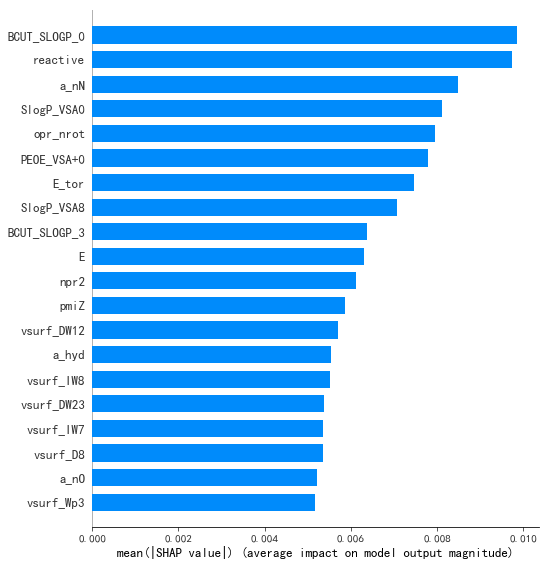

In [104]:
shap.summary_plot(shap_values=shap_values[0].reshape(168,157),
                  features = X_test11.reshape(168,157), # 所有样本的feature的值
                  feature_names=list(train.columns[1:]), # 特征的名字
                  plot_type = 'bar',
                  max_display=20,
                  show=True)

In [212]:
def calc_specificity(Y_valid,Y_pred):
    d = pd.DataFrame()
    d['true'] = Y_valid
    d['pred'] = Y_pred
    d = d.groupby(['true','pred'])['pred'].count().unstack(0)
    if not 0 in d.index:
        d = d.T
        d[0] = [0,0]
        d = d.T
    if not 1 in d.index:
        d = d.T
        d[1] = [0,0]
        d = d.T
    d = d.sort_index()
    return d.loc[0,0]/d[0].sum()

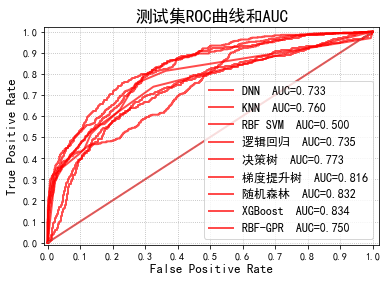

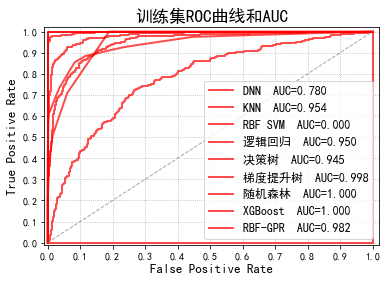

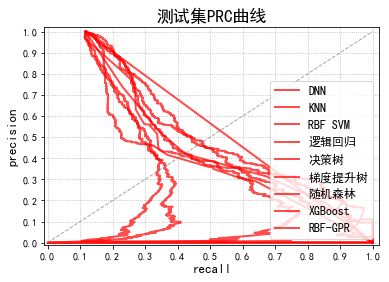

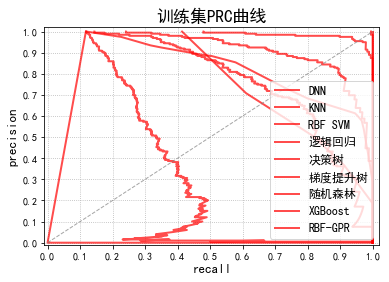

In [214]:
x1 = []
x2 = []
x3 = []
x4 = []
x0 = []
x5 = []
x6 = []
x7 = []
x8 = []
x9 = []
x10 = []
model = [dnn,rsvc,rf,xg,gpc]
model2 = ['DNN','RBF SVM','随机森林','XGBoost','RBF-GPR']
    #遍历建立每个模型，评估模型预测效果
plot_roc = {}
plot_roc1 = {}
plot_prc = {}
plot_prc1 = {}
fited_models = {}
for i,md in enumerate(model):
    y_score = md.fit(X_train.values, y_train).predict_proba(X_train.values)#得出预测概率
    fited_models[model2[i]] = md
    Y_valid = y_train
    Y_pred = md.predict(X_train.values)
    specificity1 = calc_specificity(Y_valid,Y_pred)
    precision1 = precision_score(Y_valid, Y_pred)
    recall1 = recall_score(Y_valid, Y_pred)
    y_one_hot = y_train
    precision, recall, thresholds = precision_recall_curve(y_one_hot,y_score[:,1])
    plot_prc1[model2[i]] = (precision, recall)
    fpr1, tpr1, thresholds = roc_curve(y_one_hot,y_score[:,1])
    auc1 = auc(fpr1, tpr1)
    plot_roc1[model2[i]] = (fpr1, tpr1,auc1)
    balanced_accuracy1 = balanced_accuracy_score(Y_valid, Y_pred)
    
    
    y_score = md.predict_proba(X_test.values)#得出预测概率
    Y_valid = y_test
    Y_pred = md.predict(X_test.values)
    y_one_hot = y_test
    precision, recall, thresholds = precision_recall_curve(y_one_hot,y_score[:,1])
    plot_prc[model2[i]] = (precision, recall)
    fpr, tpr, thresholds = roc_curve(y_one_hot,y_score[:,1])
    auc1 = auc(fpr, tpr)
    plot_roc[model2[i]] = (fpr, tpr,auc1)
    specificity = calc_specificity(Y_valid,Y_pred)
    precision = precision_score(Y_valid, Y_pred)
    recall = recall_score(Y_valid, Y_pred)
    acc = accuracy_score(Y_valid, Y_pred)
    f1 = f1_score(Y_valid, Y_pred)
    balanced_accuracy = balanced_accuracy_score(Y_valid, Y_pred)
    matthews = matthews_corrcoef(Y_valid, Y_pred)
    
    gft = 0.7*balanced_accuracy1 + 0.3 - 0.3*np.abs(specificity1-recall1)
    Predictivity = 0.7*balanced_accuracy + 0.3*(1-np.abs(specificity-recall))
    Robustness = 1-np.abs(balanced_accuracy1 - balanced_accuracy)
    
    x0.append(acc)
    x1.append(precision)
    x2.append(recall)
    x3.append(auc1)
    x4.append(f1)
    x5.append(specificity)
    x6.append(balanced_accuracy)
    x7.append(matthews)
    x8.append(gft)
    x9.append(Predictivity)
    x10.append(Robustness)

In [ ]:
X_train,y_train = train[train.columns[1:]].values,train[train.columns[0]].values
X_test, y_test = test[train.columns[1:]].values,test[train.columns[0]].values
X_train1 = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test1 = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

y_train1 = to_categorical(y_train,num_classes=2)
y_train1 = y_train.astype(int)
y_test1 = to_categorical(y_test,num_classes=2)
y_test1 = y_test.astype(int)

model_lstm = Sequential()
model_lstm.add(LSTM(100,input_shape=(X_train1.shape[1],X_train1.shape[2]),return_sequences=True))
model_lstm.add(Activation('relu'))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(50))
model_lstm.add(Activation('relu'))
model_lstm.add(Dense(2))
model_lstm.add(Activation('sigmoid'))
model_lstm.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model_lstm.fit(X_train1,y_train1,batch_size=5,epochs=100,validation_data=(X_test1, y_test1),verbose=0)

In [ ]:
md = model_lstm

y_score = md.fit(X_train1, y_train1).predict_proba(X_train1)
fited_models['LSTM'] = md
Y_valid = y_train1
Y_pred = md.predict(X_train1)
specificity1 = calc_specificity(Y_valid,Y_pred)
precision1 = precision_score(Y_valid, Y_pred)
recall1 = recall_score(Y_valid, Y_pred)

precision, recall, thresholds = precision_recall_curve(Y_valid,y_score[:,1])
plot_prc1['LSTM'] = (precision, recall)
fpr1, tpr1, thresholds = roc_curve(Y_valid,y_score[:,1])
auc1 = auc(fpr1, tpr1)
plot_roc1['LSTM'] = (fpr1, tpr1,auc1)
balanced_accuracy1 = balanced_accuracy_score(Y_valid, Y_pred)
    
    
y_score = md.predict_proba(X_test1)#得出预测概率
Y_valid = y_test1
Y_pred = md.predict(X_test1)
y_one_hot = y_test1
precision, recall, thresholds = precision_recall_curve(y_test1,y_score[:,1])
plot_prc['LSTM'] = (precision, recall)
fpr, tpr, thresholds = roc_curve(y_one_hot,y_score[:,1])
auc1 = auc(fpr, tpr)
plot_roc['LSTM'] = (fpr, tpr,auc1)
specificity = calc_specificity(Y_valid,Y_pred)
precision = precision_score(Y_valid, Y_pred)
recall = recall_score(Y_valid, Y_pred)
acc = accuracy_score(Y_valid, Y_pred)
f1 = f1_score(Y_valid, Y_pred)
balanced_accuracy = balanced_accuracy_score(Y_valid, Y_pred)
matthews = matthews_corrcoef(Y_valid, Y_pred)
    
gft = 0.7*balanced_accuracy1 + 0.3 - 0.3*np.abs(specificity1-recall1)
Predictivity = 0.7*balanced_accuracy + 0.3*(1-np.abs(specificity-recall))
Robustness = 1-np.abs(balanced_accuracy1 - balanced_accuracy)

x0.append(acc)
x1.append(precision)
x2.append(recall)
x3.append(auc1)
x4.append(f1)
x5.append(specificity)
x6.append(balanced_accuracy)
x7.append(matthews)
x8.append(gft)
x9.append(Predictivity)
x10.append(Robustness)

In [ ]:
X_train,y_train = train[train.columns[1:]].values,train[train.columns[0]].values
X_test, y_test = test[train.columns[1:]].values,test[train.columns[0]].values
X_train1 = X_train.reshape((X_train.shape[0],X_train.shape[1],1,1))
X_test1 = X_test.reshape((X_test.shape[0],X_test.shape[1],1,1))

model_cnn = Sequential()
model_cnn.add(Conv2D(32, (50, 1), activation='relu',
         input_shape=(157, 1,1)))
model_cnn.add(MaxPooling2D((2,1)))
model_cnn.add(Conv2D(64, (2, 1), activation='relu'))
model_cnn.add(Flatten())
model_cnn.add(Dropout(0.4))
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(1, activation='sigmoid'))
model_cnn.compile(loss='binary_crossentropy',optimizer=RMSprop(lr=1e-4),metrics=['acc'])
model_cnn.fit(X_train1,y_train1,batch_size=5,epochs=20,validation_data=(X_test1, y_test1),verbose=0)

In [ ]:
md = model_cnn

y_score = md.fit(X_train1, y_train1).predict_proba(X_train1)
fited_models['CNN'] = md
Y_valid = y_train1
Y_pred = md.predict(X_train1)
specificity1 = calc_specificity(Y_valid,Y_pred)
precision1 = precision_score(Y_valid, Y_pred)
recall1 = recall_score(Y_valid, Y_pred)

precision, recall, thresholds = precision_recall_curve(Y_valid,y_score)
plot_prc1['CNN'] = (precision, recall)
fpr1, tpr1, thresholds = roc_curve(Y_valid,y_score)
auc1 = auc(fpr1, tpr1)
plot_roc1['CNN'] = (fpr1, tpr1,auc1)
balanced_accuracy1 = balanced_accuracy_score(Y_valid, Y_pred)
    
    
y_score = md.predict_proba(X_test1)#得出预测概率
Y_valid = y_test1
Y_pred = md.predict(X_test1)
y_one_hot = y_test1
precision, recall, thresholds = precision_recall_curve(y_test1,y_score)
plot_prc['CNN'] = (precision, recall)
fpr, tpr, thresholds = roc_curve(y_one_hot,y_score)
auc1 = auc(fpr, tpr)
plot_roc['CNN'] = (fpr, tpr,auc1)
specificity = calc_specificity(Y_valid,Y_pred)
precision = precision_score(Y_valid, Y_pred)
recall = recall_score(Y_valid, Y_pred)
acc = accuracy_score(Y_valid, Y_pred)
f1 = f1_score(Y_valid, Y_pred)
balanced_accuracy = balanced_accuracy_score(Y_valid, Y_pred)
matthews = matthews_corrcoef(Y_valid, Y_pred)

gft = 0.7*balanced_accuracy1 + 0.3 - 0.3*np.abs(specificity1-recall1)
Predictivity = 0.7*balanced_accuracy + 0.3*(1-np.abs(specificity-recall))
Robustness = 1-np.abs(balanced_accuracy1 - balanced_accuracy)

x0.append(acc)
x1.append(precision)
x2.append(recall)
x3.append(auc1)
x4.append(f1)
x5.append(specificity)
x6.append(balanced_accuracy)
x7.append(matthews)
x8.append(gft)
x9.append(Predictivity)
x10.append(Robustness)

In [ ]:
model2.append('LSTM')
model2.append('CNN')
res = pd.DataFrame()
res['模型'] = model2
res['准确率'] = x0
res['精确度'] = x1
res['特异度'] = x5
res['召回率'] = x2
res['NER'] = x6
res['MCC'] = x7
res['goodness of fit'] = x8
res['predictivity'] = x9
res['robustness'] = x10
res['f1_score'] = x4
res['AUC值'] = x3

In [ ]:
round(res,5).to_csv('1效果报告.csv',index=False,encoding='utf-8-sig')
res.style.background_gradient('autumn')

In [ ]:
colors = ['red', 'blue',"black",'pink','yellow','gray','orange']
lw=1.2
plt.figure(dpi=1000,figsize=(12,8))
for k,v in plot_roc.items():
    plt.plot(v[0], v[1], c = colors[model2.index(k)], lw = 2, alpha = 0.7, label =k+ u'  AUC=%.3f' % v[2])
plt.plot((0, 1), (0, 1), c = '#808080', lw = 1, ls = '--', alpha = 0.7)
plt.xlim((-0.01, 1.02))
plt.ylim((-0.01, 1.02))
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.grid(b=True, ls=':')
plt.legend(loc='lower right', fancybox=True, framealpha=0.8, fontsize=12)
plt.title('测试集ROC曲线和AUC', fontsize=17)
plt.show()

lw=1.2
plt.figure(dpi=1000,figsize=(12,8))
for k,v in plot_roc1.items():
    plt.plot(v[0], v[1], c = colors[model2.index(k)], lw = 2, alpha = 0.7, label =k+ u'  AUC=%.3f' % v[2])
plt.plot((0, 1), (0, 1), c = '#808080', lw = 1, ls = '--', alpha = 0.7)
plt.xlim((-0.01, 1.02))
plt.ylim((-0.01, 1.02))
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.grid(b=True, ls=':')
plt.legend(loc='lower right', fancybox=True, framealpha=0.8, fontsize=12)
plt.title('训练集ROC曲线和AUC', fontsize=17)
plt.show()

lw=1.2
plt.figure(dpi=1000,figsize=(12,8))
for k,v in plot_prc.items():
    plt.plot(v[0], v[1], c = colors[model2.index(k)], lw = 2, alpha = 0.7, label =k)
plt.plot((0, 1), (0, 1), c = '#808080', lw = 1, ls = '--', alpha = 0.7)
plt.xlim((-0.01, 1.02))
plt.ylim((-0.01, 1.02))
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('recall', fontsize=13)
plt.ylabel('precision', fontsize=13)
plt.grid(b=True, ls=':')
plt.legend(loc='lower right', fancybox=True, framealpha=0.8, fontsize=12)
plt.title('测试集PRC曲线', fontsize=17)
plt.show()

lw=1.2
plt.figure(dpi=1000,figsize=(12,8))
for k,v in plot_prc1.items():
    plt.plot(v[0], v[1], c = colors[model2.index(k)], lw = 2, alpha = 0.7, label =k)
plt.plot((0, 1), (0, 1), c = '#808080', lw = 1, ls = '--', alpha = 0.7)
plt.xlim((-0.01, 1.02))
plt.ylim((-0.01, 1.02))
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('recall', fontsize=13)
plt.ylabel('precision', fontsize=13)
plt.grid(b=True, ls=':')
plt.legend(loc='lower right', fancybox=True, framealpha=0.8, fontsize=12)
plt.title('训练集PRC曲线', fontsize=17)
plt.show()

In [215]:
res.style.background_gradient('autumn')

,模型,准确率,精确度,召回率,NER,MCC,goodness of fit,predictivity,robustness,f1_score,AUC值
0,DNN,0.863988,0.93965,0.289823,0.614737,0.261062,0.663758,0.535367,0.931928,0.331646,0.733231
1,KNN,0.866048,0.924781,0.420354,0.672568,0.346471,0.679128,0.619469,0.926517,0.422222,0.760262
2,RBF SVM,0.883565,1,0,0.5,0,1,0.35,0.5,0,0.5
3,逻辑回归,0.832818,0.887464,0.418142,0.652803,0.275947,0.708491,0.616165,0.884474,0.368062,0.734504
4,决策树,0.88305,0.952187,0.358407,0.655297,0.359186,0.748258,0.580574,0.851113,0.416452,0.772596
5,梯度提升树,0.8712,0.931487,0.413717,0.672602,0.355711,0.905276,0.61549,0.745466,0.427918,0.816455
6,随机森林,0.905719,0.983965,0.311947,0.647956,0.433484,0.96407,0.551964,0.675594,0.435185,0.831621
7,XGBoost,0.879959,0.936152,0.45354,0.694846,0.400721,1,0.641608,0.694846,0.468037,0.833519
8,RBF-GPR,0.840031,0.893294,0.435841,0.664568,0.299801,0.764589,0.627961,0.847821,0.388177,0.74968


In [19]:
shap.KernelExplainer
shap.DeepExplainer
shap.TreeExplainer

shap.explainers._tree.Tree